# Customer Review Analysis for Richmond Hill Hotels

## Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# importing useful libraries

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
import geopy
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-2-49b0694a4fe3>:52: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde


In [3]:
columnNames = ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode']

hotelDf = pd.read_csv('/content/gdrive/MyDrive/reviews.csv',
                          header=None,
                          names=columnNames)
hotelDf.head()

filePath  \
0  data\ca\181740\1027324\102698054.html   
1  data\ca\181740\1027324\102859292.html   
2  data\ca\181740\1027324\103112201.html   
3  data\ca\181740\1027324\106666016.html   
4  data\ca\181740\1027324\106726059.html   

                                           hotelName  \
0  Holiday Inn Express &amp; Suites Toronto - Mar...   
1  Holiday Inn Express &amp; Suites Toronto - Mar...   
2  Holiday Inn Express &amp; Suites Toronto - Mar...   
3  Holiday Inn Express &amp; Suites Toronto - Mar...   
4  Holiday Inn Express &amp; Suites Toronto - Mar...   

                                        reviewColumn  ratingScore groundTruth  \
0  "We booked our relatives into this hotel for a...            5    positive   
1  "Based on reviews I read of this hotel I decid...            5    positive   
2  "I have stayed at this hotel several times ove...            3    negative   
3  "I was here on work the second time in 12 mont...            4    positive   
4  "We stayed at the hotel for couple nights at t...            3    negative   

      date_stamp          streetAddress                City Province  \
0  April 3, 2011  10 East Pearce Street  ('Richmond Hill',)  Ontario   
1  April 5, 2011  10 East Pearce Street  ('Richmond Hill',)  Ontario   
2  April 6, 2011  10 East Pearce Street  ('Richmond Hill',)  Ontario   
3    May 3, 2011  10 East Pearce Street  ('Richmond Hill',)  Ontario   
4    May 3, 2011  10 East Pearce Street  ('Richmond Hill',)  Ontario   

  postalCode  
0    L4B 0A8  
1    L4B 0A8  
2    L4B 0A8  
3    L4B 0A8  
4    L4B 0A8

In [4]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf

    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [5]:
reviews = hotelDf['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df = True, columns = ['reviewCol','vader_sentiment'])
reviewDF.head()

100%|██████████| 2060/2060 [00:09<00:00, 208.11it/s]


reviewCol  vader_sentiment
0  "We booked our relatives into this hotel for a...           0.9741
1  "Based on reviews I read of this hotel I decid...           0.9485
2  "I have stayed at this hotel several times ove...           0.8166
3  "I was here on work the second time in 12 mont...           0.9690
4  "We stayed at the hotel for couple nights at t...          -0.5382

In [6]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update([word.lower()
                            for word
                            in re.findall(r'\w+', review)
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values

    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)


    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [7]:
topk = getTopKWords(reviewDF, 500)
finaldf = dataFrameTransformation(hotelDf, reviewDF, topk)
finaldf.head()

hotelName  ratingScore groundTruth  \
0  Holiday Inn Express &amp; Suites Toronto - Mar...            5    positive   
1  Holiday Inn Express &amp; Suites Toronto - Mar...            5    positive   
2  Holiday Inn Express &amp; Suites Toronto - Mar...            3    negative   
3  Holiday Inn Express &amp; Suites Toronto - Mar...            4    positive   
4  Holiday Inn Express &amp; Suites Toronto - Mar...            3    negative   

                                           reviewCol  vader_sentiment  \
0  "We booked our relatives into this hotel for a...           0.9741   
1  "Based on reviews I read of this hotel I decid...           0.9485   
2  "I have stayed at this hotel several times ove...           0.8166   
3  "I was here on work the second time in 12 mont...           0.9690   
4  "We stayed at the hotel for couple nights at t...          -0.5382   

   breakfast  clean  good  great  would  ...  waiting  looks  charged  town  \
0          1      0     0      1      0  ...        0      0        0     0   
1          0      0     1      0      0  ...        0      0        0     0   
2          0      1     0      0      0  ...        0      0        0     0   
3          1      1     1      1      0  ...        0      0        0     0   
4          0      1     0      0      0  ...        0      0        0     0   

   party  sitting  less  package  okay  reason  
0      0        0     0        0     0       0  
1      0        0     0        0     0       0  
2      0        0     0        0     0       0  
3      0        0     0        0     0       0  
4      0        0     0        0     0       0  

[5 rows x 505 columns]

So far
1. hotelDf contains original data.
2. reviewDF contains all the reviews and their corresponding vader_sentiment score
3. finalDf has hotelName, ratingScore, groundTruth, reviewCol, vader_sentiment(from reviewDF) and onehot encoding of the review's corresponding most frequent 500 words after removing stop words



## Sentiment Analysis and Aggregation

In [8]:
hotelNames = finaldf['hotelName'].unique()
for hotel in hotelNames:
    print(hotel)

Holiday Inn Express &amp; Suites Toronto - Markham, an IHG Hotel
Canadas Best Value Inn Richmond Hill Toronto N
Best Western Parkway Hotel Toronto North
Sheraton Parkway Toronto North Hotel &amp; Suites
Hotel Richmond Hill ON North
Travelodge Richmond Hill


In [9]:
# Rank hotels by (i) Average Ground Truth Sentiment
measure = "ratingScore"
hotelRating = []
for hotel in hotelNames:
    itemDf = finaldf.loc[finaldf['hotelName']==hotel]
    hotelRating.append([hotel, itemDf[measure].mean()])
hotelRatingDfAGT = pd.DataFrame(hotelRating)
hotelRatingDfAGT.columns=['hotelName', 'avg_'+measure]
hotelRatingDfAGT = hotelRatingDfAGT.sort_values('avg_'+measure, ascending=0)
hotelRatingDfAGT

hotelName  avg_ratingScore
0  Holiday Inn Express &amp; Suites Toronto - Mar...         4.068100
2           Best Western Parkway Hotel Toronto North         3.800353
3  Sheraton Parkway Toronto North Hotel &amp; Suites         3.777070
1     Canadas Best Value Inn Richmond Hill Toronto N         3.419355
5                           Travelodge Richmond Hill         3.101781
4                       Hotel Richmond Hill ON North         2.833333

In [10]:
# Rank hotels by (ii) Average Vader Compound Sentiment Score
measure = "vader_sentiment"
hotelRating = []
for hotel in hotelNames:
    itemDf = finaldf.loc[finaldf['hotelName'] == hotel]
    hotelRating.append([hotel,itemDf[measure].mean()])
hotelRatingDfAVS = pd.DataFrame(hotelRating)
hotelRatingDfAVS.columns=['hotelName', 'avg_'+measure]
hotelRatingDfAVS = hotelRatingDfAVS.sort_values('avg_'+measure, ascending=0)
hotelRatingDfAVS

hotelName  avg_vader_sentiment
0  Holiday Inn Express &amp; Suites Toronto - Mar...             0.764348
3  Sheraton Parkway Toronto North Hotel &amp; Suites             0.679946
2           Best Western Parkway Hotel Toronto North             0.679168
1     Canadas Best Value Inn Richmond Hill Toronto N             0.671152
5                           Travelodge Richmond Hill             0.412877
4                       Hotel Richmond Hill ON North             0.293083

In [11]:
# Rank hotels by (iii) Median Vader Compound Sentiment Score
measure = "vader_sentiment"
hotelRating = []
for hotel in hotelNames:
    itemDf = finaldf.loc[finaldf['hotelName'] == hotel]
    hotelRating.append([hotel, itemDf[measure].median()])
hotelRatingDfMVS = pd.DataFrame(hotelRating)
hotelRatingDfMVS.columns=['hotelName', 'md_'+measure]
hotelRatingDfMVS = hotelRatingDfMVS.sort_values('md_'+measure, ascending=0)
hotelRatingDfMVS

hotelName  md_vader_sentiment
0  Holiday Inn Express &amp; Suites Toronto - Mar...              0.9447
3  Sheraton Parkway Toronto North Hotel &amp; Suites              0.9346
2           Best Western Parkway Hotel Toronto North              0.9269
1     Canadas Best Value Inn Richmond Hill Toronto N              0.9098
4                       Hotel Richmond Hill ON North              0.8555
5                           Travelodge Richmond Hill              0.7750

From above we can see the ranking given by different measures give different results. Average Ground Truth Sentiment and Average Vader Compound Sentiment Score rankings disagree at 2nd and 3rd. Average Vader Compound Sentiment Score and Median Vader Compound Sentiment Score disagree at 5th and 6th.

## Frequency Analysis

In [12]:
wordcloud_args = dict(
    width = 800,
    height = 800,
    background_color ='white',
    min_font_size = 10,
    font_path = '/content/gdrive/MyDrive/Roboto-Regular.ttf'
    )

# fucntion to plot word cloud
def plotWordCloud(dictionary, **kwargs):
    wordcloud = WordCloud(**kwargs)

    wordcloud.generate_from_frequencies(dict(dictionary))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Below we use term frequency to rank the top-50 most frequent non-stop words in both ground truth (i) positive reviews and (ii) negative reviews. Inaddition, the word cloud for each category are plotted.

In [13]:
reviewPos = finaldf[finaldf['groundTruth']=='positive'][['reviewCol']]
reviewPos.head()

reviewCol
0  "We booked our relatives into this hotel for a...
1  "Based on reviews I read of this hotel I decid...
3  "I was here on work the second time in 12 mont...
5  "Traveling on business, this was my first stay...
7  "An excellent, well managed property.  The roo...

In [14]:
topkGroundPos = getTopKWords(reviewPos, 50)
topkGroundPos

[('great', 723),
 ('breakfast', 685),
 ('clean', 684),
 ('good', 642),
 ('nice', 491),
 ('would', 415),
 ('comfortable', 408),
 ('stayed', 405),
 ('friendly', 400),
 ('well', 370),
 ('service', 358),
 ('one', 355),
 ('area', 337),
 ('sheraton', 315),
 ('free', 299),
 ('time', 297),
 ('nthe', 277),
 ('parking', 273),
 ('desk', 265),
 ('helpful', 263),
 ('location', 263),
 ('toronto', 260),
 ('pool', 257),
 ('best', 257),
 ('also', 256),
 ('food', 241),
 ('front', 240),
 ('bed', 238),
 ('excellent', 232),
 ('night', 223),
 ('really', 222),
 ('restaurant', 219),
 ('get', 218),
 ('back', 207),
 ('like', 204),
 ('restaurants', 201),
 ('check', 198),
 ('always', 195),
 ('next', 193),
 ('beds', 187),
 ('business', 184),
 ('close', 178),
 ('could', 176),
 ('place', 176),
 ('lobby', 164),
 ('recommend', 164),
 ('day', 155),
 ('two', 153),
 ('buffet', 153),
 ('easy', 148)]

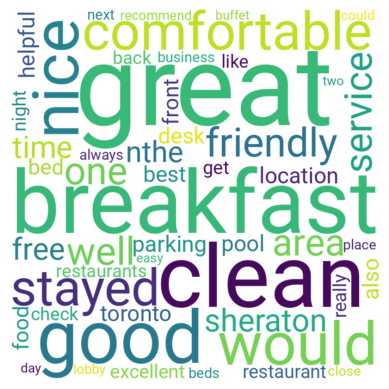

In [15]:
plotWordCloud(topkGroundPos, **wordcloud_args)

In [16]:
reviewNeg = finaldf[finaldf['groundTruth']=='negative'][['reviewCol']]
reviewNeg.head()

reviewCol
2   "I have stayed at this hotel several times ove...
4   "We stayed at the hotel for couple nights at t...
6   "Came to hotel looking forward to swimming in ...
30  "All the previous reviews created high expecta...
31  "Pretty standard hotel. Lots of money spent on...

In [17]:
topkGroundNeg = getTopKWords(reviewNeg, 50)
topkGroundNeg

[('breakfast', 345),
 ('would', 342),
 ('one', 336),
 ('good', 303),
 ('desk', 299),
 ('night', 296),
 ('front', 290),
 ('clean', 278),
 ('bed', 264),
 ('stayed', 243),
 ('get', 242),
 ('nthe', 241),
 ('sheraton', 241),
 ('like', 240),
 ('time', 221),
 ('service', 205),
 ('could', 201),
 ('pool', 199),
 ('area', 191),
 ('nice', 181),
 ('check', 179),
 ('bathroom', 179),
 ('back', 177),
 ('floor', 176),
 ('even', 164),
 ('next', 163),
 ('told', 162),
 ('door', 162),
 ('parking', 161),
 ('also', 160),
 ('day', 160),
 ('place', 151),
 ('asked', 146),
 ('great', 143),
 ('well', 140),
 ('got', 139),
 ('said', 138),
 ('never', 136),
 ('location', 136),
 ('first', 128),
 ('friendly', 127),
 ('small', 127),
 ('old', 126),
 ('free', 125),
 ('u2019t', 123),
 ('shower', 122),
 ('lobby', 121),
 ('people', 117),
 ('best', 116),
 ('called', 115)]

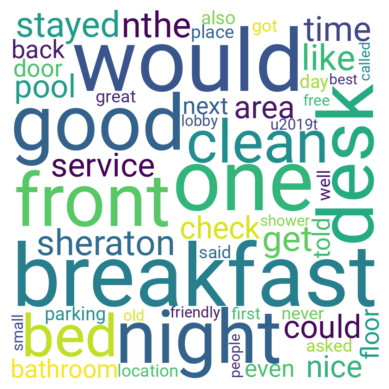

In [18]:
plotWordCloud(topkGroundNeg, **wordcloud_args)

In [19]:
intersection_list = [x[0] for x in topkGroundNeg if x[0] in set(y[0] for y in topkGroundPos)]
intersection_list

['breakfast',
 'would',
 'one',
 'good',
 'desk',
 'night',
 'front',
 'clean',
 'bed',
 'stayed',
 'get',
 'nthe',
 'sheraton',
 'like',
 'time',
 'service',
 'could',
 'pool',
 'area',
 'nice',
 'check',
 'back',
 'next',
 'parking',
 'also',
 'day',
 'place',
 'great',
 'well',
 'location',
 'friendly',
 'free',
 'lobby',
 'best']


From above we can see some words are location specific such as "toronto".


Some words appear in both positive and negative reviews:


['breakfast', 'would', 'one', 'good', 'desk', 'night', 'front', 'clean', 'bed', 'stayed', 'get', 'nthe', 'sheraton', 'like', 'time', 'service', 'could', 'pool', 'area', 'nice', 'check', 'back', 'next', 'parking', 'also', 'day', 'place', 'great', 'well', 'location', 'friendly', 'free', 'lobby', 'best']


An interesting thing is that positive adjectives like "good", "clean", "nice", "great", "well", "best" appears in both positive and negative reviews

We repeat the analysis above for the top-50 noun phrases (using the provided grammar pattern below).

In [20]:
# to make the results more useable, we clean up the tree results shown above.
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>} # Nouns and Adjectives, terminated with Nouns
    NP:
        {<NBAR><IN><NBAR>}
        {<NBAR>} # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)
tagger = PerceptronTagger()
pos_tag = tagger.tag

# generator, create item one a time
def get_terms(tree, remove_stopwords=True):
    for leaf in leaves(tree):

        term = []

        for w, t in leaf:
            if remove_stopwords:
                if acceptable_word(w):
                    term.append(normalise(w))

            else:
                term.append(normalise(w))

        # Phrase only
        if len(term) > 1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case...
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        if len(token) > 0: # don't return empty tokens
            finalList.append(token.rstrip())
    return finalList

# getting top noun phrases
def getTopKNP(df, kNPs):

    counter = Counter()
    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))
                            ]))
    topk = counter.most_common(kNPs)
    return topk

In [21]:
topkGroundPosNP = getTopKNP(reviewPos, 50)
topkGroundPosNP

[('front desk', 122),
 ('best western', 50),
 ('richmond hill', 40),
 ('sheraton parkway', 38),
 ('tim horton', 32),
 ('club loung', 28),
 ('breakfast buffet', 26),
 ('first time', 24),
 ('free breakfast', 22),
 ('canada wonderland', 22),
 ('great experi', 21),
 ('holiday inn express', 20),
 ('comfort bed', 20),
 ('next time', 19),
 ('complimentari breakfast', 19),
 ('outdoor pool', 19),
 ('next day', 18),
 ('continent breakfast', 18),
 ('park lot', 18),
 ('great place', 17),
 ('custom servic', 16),
 ('good valu', 16),
 ('great locat', 16),
 ('next door', 16),
 ('indoor pool', 16),
 ('buffet breakfast', 15),
 ('queen bed', 14),
 ('lot restaur', 14),
 ('hot tub', 14),
 ('holiday inn', 13),
 ('busi trip', 13),
 ('next morn', 13),
 ('easi access', 13),
 ('excel servic', 13),
 ('coffe maker', 12),
 ('ground floor', 12),
 ('second time', 11),
 ('mani restaur', 11),
 ('free park', 11),
 ('conveni locat', 11),
 ('last year', 11),
 ('good locat', 11),
 ('downtown toronto', 11),
 ('mini fridg',

In [22]:
topkGroundNegNP = getTopKNP(reviewNeg, 50)
topkGroundNegNP

[('front desk', 148),
 ('park lot', 32),
 ('best western', 27),
 ('custom servic', 24),
 ('credit card', 24),
 ('free breakfast', 18),
 ('next morn', 16),
 ('doubl bed', 14),
 ('non smoke', 14),
 ('outdoor pool', 14),
 ('hot tub', 13),
 ('indoor pool', 13),
 ('next day', 13),
 ('club loung', 13),
 ('coffe maker', 12),
 ('sheraton next door', 12),
 ('pool area', 12),
 ('bed bug', 12),
 ('busi trip', 11),
 ('first time', 11),
 ('tim horton', 11),
 ('queen bed', 10),
 ('holiday inn express', 9),
 ('late check', 9),
 ('next door', 9),
 ('continent breakfast', 9),
 ('patio door', 9),
 ('hot water', 9),
 ('sever time', 8),
 ('king bed', 8),
 ('ground floor', 8),
 ('breakfast buffet', 8),
 ('good thing', 8),
 ('canada wonderland', 8),
 ('hockey tournament', 8),
 ('sheraton parkway', 8),
 ('next time', 7),
 ('front lobbi', 7),
 ('long time', 7),
 ('last night', 7),
 ('second floor', 7),
 ('bottl water', 7),
 ('mani time', 7),
 ('last year', 6),
 ('mani hotel', 6),
 ('half hour', 6),
 ('first n

In [23]:
intersection_list = [x[0] for x in topkGroundPosNP if x[0] in set(y[0] for y in topkGroundNegNP)]
intersection_list

['front desk',
 'best western',
 'sheraton parkway',
 'tim horton',
 'club loung',
 'breakfast buffet',
 'first time',
 'free breakfast',
 'canada wonderland',
 'holiday inn express',
 'next time',
 'outdoor pool',
 'next day',
 'continent breakfast',
 'park lot',
 'custom servic',
 'next door',
 'indoor pool',
 'queen bed',
 'hot tub',
 'busi trip',
 'next morn',
 'coffe maker',
 'ground floor',
 'last year']

Noun phrases appear in both positive and negative reviews are listed below:


['front desk', 'richmond hill', 'best western', 'sheraton parkway', 'tim horton', 'canada wonderland', 'club loung', 'breakfast buffet', 'free breakfast', 'holiday inn express', 'first time', 'park lot', 'outdoor pool', 'next day', 'continent breakfast', 'next time', 'indoor pool', 'custom servic', 'next door', 'good locat', 'hot tub', 'busi trip', 'queen bed', 'coffe maker', 'next morn', 'ground floor', 'pool area', 'busi travel']


Surprisingly "busy travel" appears in both list. "busy" typically has a negative connotation when describing travel. "busy travel" appears in a positive review, it might suggest that the reviewer actually enjoyed the energetic atmosphere of the travel experience in hotels.

## Mutual Information Analysis

 In this section we use mutual information (MI) with ground truth sentiment to rank the top-50 most sentiment bearing non-stopwords in the review collection. The corresponding word cloud is provided help visualize the result.

In [28]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [29]:
topkMI = getTopKWords(finaldf[['reviewCol']] , 50)
MIdf = dataFrameTransformation(hotelDf, reviewDF, topkMI)
miScoredf = getMI(topkMI, MIdf)
miScoredf

Word      MI Score
3         great  2.901928e-02
14  comfortable  1.607299e-02
40     bathroom  1.370348e-02
45    excellent  1.335285e-02
36      helpful  1.318313e-02
13     friendly  1.242199e-02
15        night  1.161384e-02
1         clean  1.148111e-02
41        floor  9.205094e-03
44         door  8.966205e-03
22         like  8.818868e-03
0     breakfast  7.361943e-03
11        front  7.334850e-03
8          desk  6.799305e-03
48  restaurants  6.608641e-03
29        could  6.513864e-03
5           one  5.274743e-03
20          get  5.259838e-03
33      toronto  5.241500e-03
18         well  5.166477e-03
38         even  4.729702e-03
39   restaurant  4.475669e-03
6          nice  3.906715e-03
32         food  3.170146e-03
19          bed  2.918104e-03
37          day  2.900655e-03
27         back  1.905253e-03
28        check  1.864052e-03
2          good  1.733286e-03
31         next  1.383981e-03
17         nthe  1.152254e-03
24         free  1.126066e-03
4         would  1.107491e-03
30         best  9.542927e-04
16         time  9.497536e-04
35        place  9.140510e-04
46     business  6.609871e-04
9       service  6.519887e-04
49        close  6.024413e-04
47          two  5.569209e-04
12         area  5.236937e-04
10     sheraton  5.161374e-04
42        lobby  4.608468e-04
26     location  4.586085e-04
43         beds  3.432846e-04
23      parking  1.020536e-04
21         pool  4.084371e-05
34       really  1.004130e-05
7        stayed  3.508655e-06
25         also  5.575834e-07

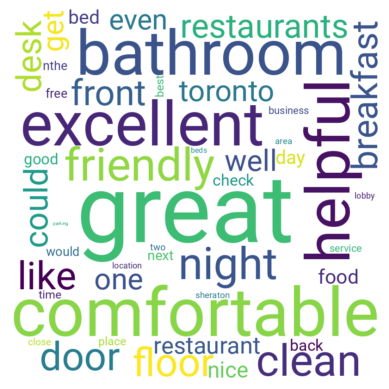

In [30]:
plotWordCloud(miScoredf.set_index('Word')['MI Score'].to_dict(), **wordcloud_args)

From above we can see "great" gets the highest MI values.

Mutual information is a measure of the amount of information that knowing the value of one variable provides about another variable. In this case, it means that knowing "great" provides information of "postive" or "negative. This makes sense since "great" is a positive word.

Now we repeat the analysis for the top-50 noun phrases using the same grammar in frequency analysis.

In [31]:
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>} # Nouns and Adjectives, terminated with Nouns
    NP:
        {<NBAR><IN><NBAR>}
        {<NBAR>} # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)
tagger = PerceptronTagger()
pos_tag = tagger.tag

def NPdataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values

    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word
                                       for word
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)


    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [32]:
topkMI_phrase = getTopKNP(finaldf[['reviewCol']], 50)
MIdf_phrase = NPdataFrameTransformation(hotelDf, reviewDF, topkMI_phrase)
miScoredf = getMI(topkMI_phrase , MIdf_phrase)
miScoredf

Word      MI Score
0                front desk  5.858453e-03
48                non smoke  4.838824e-03
17              credit card  4.250515e-03
4             richmond hill  3.580603e-03
2                  park lot  3.264948e-03
27             great experi  2.990670e-03
8             custom servic  2.216791e-03
29                doubl bed  1.616129e-03
3          sheraton parkway  1.533477e-03
47             excel servic  1.002321e-03
46              easi access  1.002321e-03
32       sheraton next door  8.892979e-04
16                next morn  8.145002e-04
21              comfort bed  8.043874e-04
30              great place  7.596017e-04
36         buffet breakfast  7.239218e-04
26  complimentari breakfast  6.921083e-04
28                pool area  6.487234e-04
34              great locat  6.420738e-04
5                tim horton  5.933160e-04
6                club loung  5.504407e-04
10         breakfast buffet  4.883704e-04
38              holiday inn  4.804831e-04
42                 king bed  4.214644e-04
31                good valu  3.903295e-04
49               sever time  3.874116e-04
7            free breakfast  2.974461e-04
25              coffe maker  2.939626e-04
20                next time  2.726851e-04
13        canada wonderland  2.634744e-04
35              lot restaur  2.249889e-04
24                busi trip  2.081331e-04
23                queen bed  1.753557e-04
43            conveni locat  1.651165e-04
44               mini fridg  1.651165e-04
45               good place  1.651165e-04
41        hockey tournament  1.537652e-04
9                first time  1.037661e-04
19      continent breakfast  9.766502e-05
14      holiday inn express  5.834552e-05
40                last time  5.031769e-05
39               good locat  5.031769e-05
18                  hot tub  4.154680e-05
15              indoor pool  2.933482e-05
33             ground floor  2.340964e-05
11             outdoor pool  2.041471e-05
22                next door  1.482215e-05
1              best western  1.359472e-05
37                last year  1.212694e-06
12                 next day  4.267356e-07

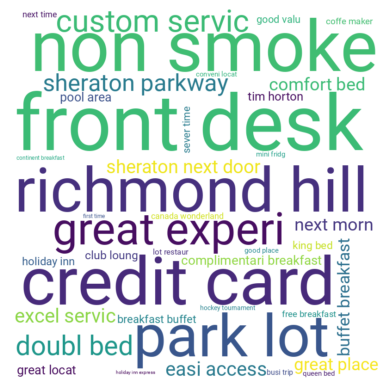

In [33]:
plotWordCloud(miScoredf.set_index('Word')['MI Score'].to_dict(), **wordcloud_args)

We can see "front desk" get the highest MI values.


Based on these results, the following are some suggestions for the hotels in Richmond Hill.


Since "front desk," "non smoke," and "credit card" have highest scores (which means they highly associate with customers' experience with a hotel). I recommend the following:
1. Maintain and enhance positive aspects of front desk service, possibly by providing excellent customer service
2. Continue to uphold and promote a clean, smoke-free environment
3. Maintain a secure and fast credit card payment process

## Pointwise Mutual Information

We calculate the top-50 words according to Pointwise Mutual Information (PMI) of the word occurring with (i) positive reviews and (ii) negative reviews. The word clouds for each category are shown accordingly.

In [34]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe

    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)

    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):

    N = df.shape[0]

    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])

    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

In [35]:
topkPMI = getTopKWords(finaldf[['reviewCol']], 500)
pmiposdf = pmiForAllCal(finaldf, topkPMI, 'positive')
pmiposdf.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:01<00:00, 467.60it/s]


pmi
highly         0.370981
delicious      0.361193
fantastic      0.361193
thank          0.356419
awesome        0.341434
loved           0.33872
love            0.33872
amazing         0.33872
wonderful       0.33134
enjoyed        0.330623
thanks         0.329751
spacious       0.320701
super          0.315921
courteous      0.313402
appreciated    0.298874
excellent      0.290268
places          0.28788
perfect        0.282839
variety        0.274181
easy           0.272983
modern         0.260758
definitely     0.255178
distance       0.253791
polite         0.253562
helpful         0.24962
within         0.247411
dining         0.246782
north          0.246431
great          0.243244
beautiful      0.242093
shopping        0.24028
updated        0.238249
impressed      0.229113
selection      0.227661
404            0.226929
downtown       0.221383
buffet         0.217429
surprised       0.21683
comfortable    0.215912
everyone        0.21138
restaurants    0.209979
accommodating  0.207607
fresh          0.207042
quiet           0.20416
407            0.202269
pleasant       0.202269
recommend      0.200369
professional   0.198674
parkway        0.196992
lovely          0.19181

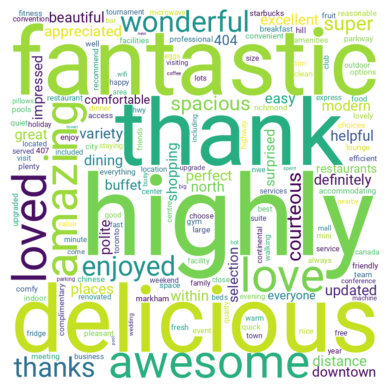

In [36]:
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

In [37]:
pminegdf = pmiForAllCal(finaldf, topkPMI, 'negative')
pminegdf.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:01<00:00, 291.99it/s]


pmi
dirty        0.918844
worst        0.896113
cleaned       0.88596
charged       0.88596
tired        0.849593
smoking      0.830472
smell        0.815152
carpet       0.811853
smoke        0.803073
toilet         0.7806
hair         0.770129
credit       0.760121
smelled      0.752429
poor          0.74346
walls        0.741379
told         0.711356
least        0.708944
called       0.674264
old          0.673786
hallway      0.673502
sheets       0.672386
pay          0.669737
tried        0.667271
asked        0.639951
reservation  0.638284
okay         0.636019
loud          0.63218
never        0.625677
phone        0.625677
hear         0.624254
someone      0.622376
noisy        0.616971
air          0.613546
seemed       0.612265
call         0.610701
bad          0.602733
another      0.602031
line         0.598278
said         0.594172
let          0.587583
cold         0.583241
non          0.581749
change       0.570108
u2019t       0.569705
left         0.568425
either       0.559812
security     0.559058
probably     0.554218
thought      0.549007
checked      0.547925

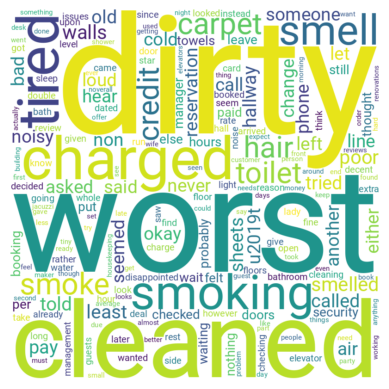

In [38]:
plotWordCloud(pminegdf['pmi'].to_dict(), **wordcloud_args)

Here are some interesting findings about these top-ranked words:

1. "awesome","delicious","fantastic" indicate positive reviews.
2. "dirty", "charged", "worst" indicate negative reviews.
3. What's interesting is that "cleaned" is a negative indicater. This might be caused by negation (i.e. "not cleaned" is in fact a negative indicator) or sarcasm.
4. highway "404" and "407" indicate positive reviews
5. negative word list have much higher PMI socre than positive words

We repeat this analysis for the top-50 noun phrases.

In [39]:
topkPMI_phrase = getTopKNP(finaldf[['reviewCol']], 500)
PMIdf_phrase = NPdataFrameTransformation(hotelDf, reviewDF, topkPMI_phrase)

In [40]:
pmiposdf_phrase = pmiForAllCal(PMIdf_phrase , topkPMI_phrase, 'positive')
pmiposdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 563.47it/s]


pmi
last week              0.456503
upper floor            0.456503
good start             0.456503
complimentari upgrad   0.456503
free upgrad            0.456503
lot chine restaur      0.456503
ga station             0.456503
pleasant surpris       0.456503
next year              0.456503
perfect locat          0.456503
clean breakfast        0.456503
nice restaur           0.456503
great custom servic    0.456503
comfi bed              0.456503
great job              0.456503
big thank              0.456503
good work              0.456503
good park              0.456503
busi center            0.456503
fit area               0.456503
pool fit centr         0.456503
whole team             0.456503
great new              0.456503
friendli breakfast     0.456503
modern look            0.456503
lot time               0.456503
share hotel            0.456503
top notch              0.456503
mini vacat             0.456503
famili vacat           0.456503
morn breakfast         0.456503
salt water             0.456503
free buffet breakfast  0.456503
bad thing              0.456503
warm welcom            0.456503
lot channel            0.456503
good choic             0.456503
chine food             0.456503
nthe servic            0.456503
great food             0.456503
super help             0.456503
quiet place            0.456503
minor issu             0.456503
great bonu             0.456503
flat screen tv         0.456503
great bed              0.456503
quick check            0.456503
great rate             0.456503
great work             0.456503
food servic            0.456503

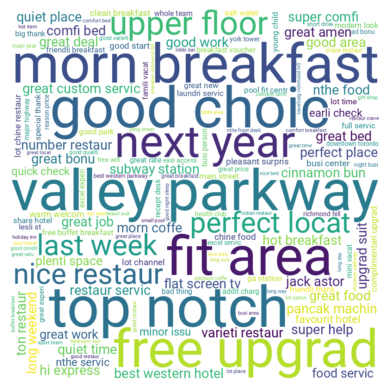

In [41]:
plotWordCloud(pmiposdf_phrase['pmi'].to_dict(), **wordcloud_args)

In [42]:
pminegdf_phrase = pmiForAllCal(PMIdf_phrase , topkPMI_phrase, 'negative')
pminegdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 562.49it/s]


pmi
recreat area      1.003744
u2019t work       1.003744
green program     1.003744
tv work           1.003744
extra blanket     1.003744
whole thing       1.003744
much nicer        1.003744
full price        1.003744
secur guard       1.003744
hallway carpet    1.003744
sheraton brand    1.003744
5th floor         1.003744
nthe next morn    1.003744
local call        1.003744
shower curtain    1.003744
travel lodg       1.003744
front lobbi       1.003744
last day          1.003744
u2019t feel       1.003744
desper need       1.003744
cab ride          1.003744
short busi trip   1.003744
internet servic   1.003744
info folder       1.003744
small child       1.003744
nthe price        1.003744
year old          1.003744
discount rate     1.003744
mainten person    1.003744
night manag       1.003744
plu side          1.003744
non smoke         0.929636
hot water          0.88596
bed bug           0.870212
half hour         0.849593
mani hotel        0.849593
littl thing       0.821422
credit card       0.792434
hair dryer          0.7806
main lobbi          0.7806
bed sheet           0.7806
poor servic         0.7806
good deal           0.7806
level servic        0.7806
last night        0.716061
bathroom door     0.716061
park spot         0.716061
second day        0.716061
overal experi     0.716061
internet connect  0.716061

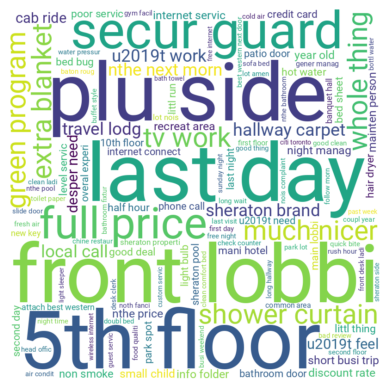

In [43]:
plotWordCloud(pminegdf_phrase['pmi'].to_dict(), **wordcloud_args)

1. From positive review side we can see people like free upgrade.
2. From negative side we can see people can give negative reviews for various reasons.
3. Both positve and negative side have a lot of phrases with same pmi score.

Now we repeat above analysis for the single top and single bottom hotel (after ranking by their average ground truth rating) and see if we can get some more interesting insights.

### single top

In [44]:
hotelDf_top = hotelDf[hotelDf['hotelName']=='Holiday Inn Express &amp; Suites Toronto - Markham, an IHG Hotel']
reviews = hotelDf_top['reviewColumn'].values
reviewDF_top = evalSentences(reviews, to_df = True, columns = ['reviewCol','vader_sentiment'])
topk_top = getTopKWords(reviewDF_top, 100)
finaldf_top = dataFrameTransformation(hotelDf_top, reviewDF_top, topk_top)

100%|██████████| 279/279 [00:00<00:00, 681.29it/s]


In [45]:
pmiposdf_top = pmiForAllCal(finaldf_top, topk_top, 'positive')
pmiposdf_top.sort_values('pmi',ascending=0).head(50)

100%|██████████| 100/100 [00:00<00:00, 884.48it/s]


pmi
definitely   0.198775
modern       0.171376
helpful       0.15585
great        0.150573
nice         0.142605
hot          0.132319
much         0.107513
excellent    0.096869
recommend    0.096869
lots         0.096869
everything   0.095591
included     0.086034
clean        0.081275
restaurants  0.080043
large        0.080043
friendly     0.073612
though       0.073612
free         0.067881
well         0.067342
breakfast    0.066691
staying      0.059223
comfortable  0.058108
area           0.0566
good          0.05632
new          0.055263
spacious     0.048294
also         0.048294
really        0.03768
coffee        0.03279
suite        0.026359
little       0.022319
within       0.022319
parking      0.022319
beds         0.018262
lot          0.014771
internet     0.014771
pool         0.010811
food         0.010811
easy         0.009073
close        0.001699
business     -0.00435
always       -0.02032
nights      -0.021698
time        -0.026634
bed         -0.031749
toronto     -0.031749
location    -0.036736
lobby       -0.041318
family      -0.044171
ever        -0.046347

In [46]:
d = pmiposdf_top.sort_values('pmi',ascending=0)['pmi'].to_dict()
counter = 0
for k in d:
    if d[k]>0 :
        counter+=1

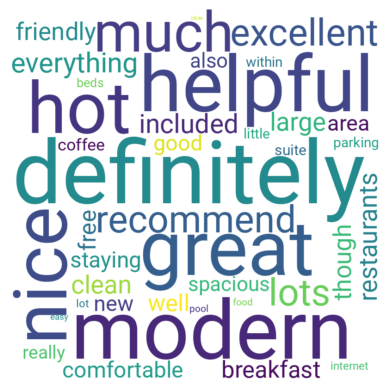

In [47]:
plotWordCloud(pmiposdf_top.sort_values('pmi',ascending=0)['pmi'].head(counter).to_dict(), **wordcloud_args)

In [48]:
pminegdf_top = pmiForAllCal(finaldf_top, topk_top, 'negative')
pminegdf_top.sort_values('pmi',ascending=0).head(50)

100%|██████████| 100/100 [00:00<00:00, 649.34it/s]


pmi
asked       1.100312
called      1.057294
told        0.977251
manager     0.846223
experience  0.837489
floor        0.79493
night        0.67304
said        0.667097
day         0.648326
right       0.640779
booked      0.640779
check       0.619039
find        0.590135
even        0.582368
way         0.571786
away        0.571786
last        0.532566
kids        0.522996
make        0.518676
work        0.507248
like        0.494825
first       0.492649
hotels      0.476476
one         0.460924
every       0.458458
got         0.423366
made        0.420236
king        0.389465
could       0.389465
bathroom    0.356675
get         0.350998
would       0.329567
use         0.294155
front       0.292838
next        0.284104
stayed      0.274154
nthe        0.260847
inn         0.260847
price       0.251314
holiday     0.243753
desk        0.241545
small       0.235314
place       0.222411
morning     0.219566
people      0.215111
express     0.207143
service     0.207143
shower      0.188794
back        0.181825
two           0.1724

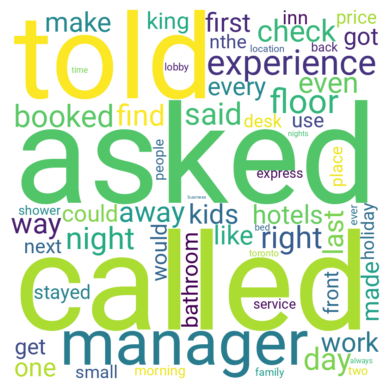

In [49]:
plotWordCloud(pminegdf_top['pmi'].to_dict(), **wordcloud_args)

In [50]:
hotelDf_top = hotelDf[hotelDf['hotelName']=='Holiday Inn Express &amp; Suites Toronto - Markham, an IHG Hotel']
reviews = hotelDf_top['reviewColumn'].values
reviewDF_top = evalSentences(reviews, to_df = True, columns = ['reviewCol','vader_sentiment'])
topk_top_phrase = getTopKNP(reviewDF_top, 100)
finaldf_top_phrase = NPdataFrameTransformation(hotelDf_top, reviewDF_top, topk_top_phrase)

100%|██████████| 279/279 [00:00<00:00, 375.45it/s]


In [51]:
pmiposdf_top_phrase = pmiForAllCal(finaldf_top_phrase, topk_top_phrase, 'positive')
pmiposdf_top_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 100/100 [00:00<00:00, 1026.53it/s]


pmi
small pool            0.255933
busi travel           0.255933
free park             0.255933
mani restaur          0.255933
great properti        0.255933
complimentari upgrad  0.255933
short drive           0.255933
littl bit             0.255933
hong kong             0.255933
nice breakfast        0.255933
bath tub              0.255933
bathroom light        0.255933
flat screen tv        0.255933
quiet time            0.255933
great experi          0.255933
breakfast bar         0.255933
downtown toronto      0.255933
great time            0.255933
great deal            0.255933
perfect place         0.255933
varieti restaur       0.255933
lot peopl             0.255933
nice perk             0.255933
ice machin            0.255933
brand new             0.255933
chine food            0.255933
king bed suit         0.255933
nice everyth          0.255933
clean breakfast       0.255933
young man             0.255933
ad bonu               0.255933
super comfi           0.255933
long day              0.255933
nice addit            0.255933
continent breakfast   0.255933
cinnamon bun          0.255933
hot breakfast         0.255933
first thing           0.255933
pool area             0.255933
pancak machin         0.255933
next morn             0.255933
hi express            0.255933
lot chine restaur     0.255933
second time           0.255933
nice touch            0.255933
good start            0.255933
richmond hill         0.255933
busi center           0.255933
next time             0.255933
free breakfast         0.13815

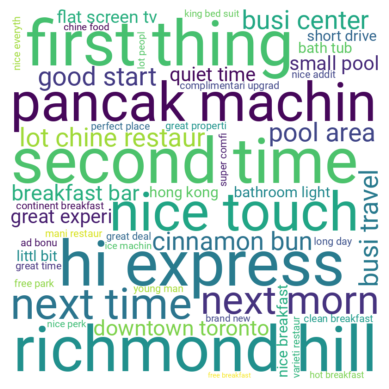

In [52]:
plotWordCloud(pmiposdf_top_phrase['pmi'].to_dict(), **wordcloud_args)

In [53]:
pminegdf_top_phrase = pmiForAllCal(finaldf_top_phrase, topk_top_phrase, 'negative')
pminegdf_top_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 100/100 [00:00<00:00, 963.05it/s]


pmi
cool u002fheat control   1.488077
info folder              1.488077
late check               1.488077
sever time               1.200395
credit card              1.082612
king size bed            1.082612
cold air                 1.082612
internet connect         1.082612
noisi neighbour           0.79493
enough time               0.79493
bar fridg                 0.79493
front desk personnel      0.79493
king size                 0.79493
swim pool                 0.79493
mani hotel                0.79493
nno bar                   0.79493
next trip                 0.79493
hot tub                   0.79493
coupl night               0.79493
coupl year                0.79493
nthe breakfast            0.79493
major highway             0.79493
frequent busi travel      0.79493
friendli park             0.79493
busi trip                0.640779
complimentari breakfast  0.571786
last time                0.571786
lot restaur              0.571786
comfort breakfast        0.389465
mini fridg               0.389465
good thing               0.389465
minut walk               0.389465
nthe locat               0.389465
good varieti             0.389465
salt water pool          0.389465
doubl bed                0.389465
king bed                 0.389465
comfort bed              0.389465
last year                0.389465
front desk               0.368845
first time               0.309422
holiday inn express      0.235314
breakfast area           0.235314
great place              0.101783
next day                 0.101783
queen bed                0.101783
coffe maker              0.101783
holiday inn             -0.052368
hot item                -0.121361
conveni locat           -0.121361

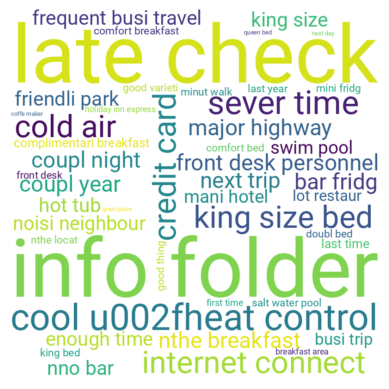

In [54]:
plotWordCloud(pminegdf_top_phrase['pmi'].to_dict(), **wordcloud_args)

### single bottom

In [55]:
hotelDf_bot = hotelDf[hotelDf['hotelName']=='Hotel Richmond Hill ON North']
hotelDf_bot.reset_index(inplace=True)
reviewDF_bot = evalSentences(hotelDf_bot['reviewColumn'].values, to_df = True, columns = ['reviewCol','vader_sentiment'])
topk_bot = getTopKWords(reviewDF_bot, 100)
finaldf_bot = dataFrameTransformation(hotelDf_bot, reviewDF_bot, topk_bot)

100%|██████████| 6/6 [00:00<00:00, 415.97it/s]


In [56]:
pmiposdf_bot = pmiForAllCal(finaldf_bot, topk_bot, 'positive')
pmiposdf_bot.sort_values('pmi',ascending=0).head(50)

100%|██████████| 100/100 [00:00<00:00, 1107.63it/s]


pmi
good       0.693147
belt       0.693147
super      0.693147
parking    0.693147
nice       0.693147
place      0.405465
area            0.0
came            0.0
richmond        0.0
hill            0.0
gave            0.0
family          0.0
need            0.0
night     -0.405465
check     -0.405465
door      -8.517193
sheets    -8.517193
opening   -8.517193
safety    -8.517193
upon      -8.517193
notified  -8.517193
happened  -8.517193
given     -8.517193
traveling -8.517193
put       -8.517193
manager   -8.517193
pointed   -8.517193
see       -8.517193
used      -8.517193
accused   -8.517193
pay       -8.517193
camera    -8.517193
instead   -8.517193
noticed   -8.517193
anyone    -8.517193
tthe      -8.517193
chair     -8.517193
late      -8.517193
card      -8.517193
desk      -8.517193
broken    -8.517193
nwe       -8.517193
car       -8.517193
checked   -8.517193
slept     -8.517193
make      -8.517193
u002f28   -8.517193
walked    -8.517193
suv       -8.517193
time      -8.517193

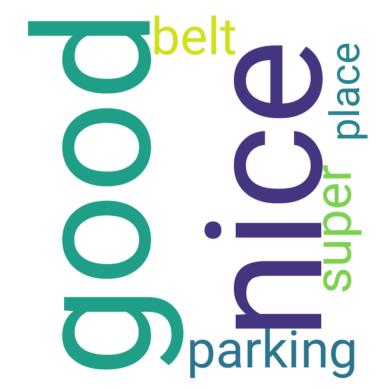

In [57]:
plotWordCloud(pmiposdf_bot['pmi'].to_dict(), **wordcloud_args)

In [58]:
pminegdf_bot = pmiForAllCal(finaldf_bot, topk_bot, 'negative')
pminegdf_bot.sort_values('pmi',ascending=0).head(50)

100%|██████████| 100/100 [00:00<00:00, 1221.90it/s]


pmi
slept      0.693147
pointed    0.693147
making     0.693147
stayed     0.693147
see        0.693147
camera     0.693147
pay        0.693147
accused    0.693147
used       0.693147
paying     0.693147
sheets     0.693147
manager    0.693147
put        0.693147
happened   0.693147
notified   0.693147
safety     0.693147
door       0.693147
opening    0.693147
upon       0.693147
two        0.693147
given      0.693147
smoke      0.693147
working    0.693147
even       0.693147
nthe       0.693147
office     0.693147
car        0.693147
nwe        0.693147
broken     0.693147
desk       0.693147
next       0.693147
card       0.693147
day        0.693147
late       0.693147
else       0.693147
coming     0.693147
smell      0.693147
bathroom   0.693147
chair      0.693147
tthe       0.693147
ignored    0.693147
anyone     0.693147
left       0.693147
quickly    0.693147
noticed    0.693147
traveling  0.693147
fair       0.693147
checked    0.693147
hold       0.693147
suv        0.693147

In [59]:
hotelDf_bot = hotelDf[hotelDf['hotelName']=='Hotel Richmond Hill ON North']
hotelDf_bot.reset_index(inplace=True)
reviewDF_bot = evalSentences(hotelDf_bot['reviewColumn'].values, to_df = True, columns = ['reviewCol','vader_sentiment'])
topk_bot_phrase = getTopKNP(reviewDF_bot, 100)
finaldf_bot_phrase = NPdataFrameTransformation(hotelDf_bot, reviewDF_bot, topk_bot_phrase)

100%|██████████| 6/6 [00:00<00:00, 350.87it/s]


In [60]:
pmiposdf_bot_phrase = pmiForAllCal(finaldf_bot_phrase, topk_bot_phrase, 'positive')
pmiposdf_bot_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 55/55 [00:00<00:00, 995.53it/s]


pmi
nice old school place bed      0.693147
seren place                    0.693147
need improv                    0.693147
richmond hill                  0.693147
super comfi                    0.693147
super help amd quick check     0.693147
mainten man                    0.693147
good restaur                   0.693147
nice place good                0.693147
non smoke                     -8.517193
funni smell                   -8.517193
magic mushroom                -8.517193
male employe owner            -8.517193
credit card                   -8.517193
stale smoke                   -8.517193
safeti other                  -8.517193
entir facil need              -8.517193
u002f28 u002f16               -8.517193
next morn                     -8.517193
area plea                     -8.517193
night nthe                    -8.517193
strong odor                   -8.517193
broken tv                     -8.517193
bathroom nwe                  -8.517193
second towel                  -8.517193
next day                      -8.517193
somewher el ye                -8.517193
facil anyon                   -8.517193
unit state                    -8.517193
bed terrifi                   -8.517193
pregnant famili member        -8.517193
famili member                 -8.517193
pregnant woman                -8.517193
late check                    -8.517193
richmond hill via car         -8.517193
first interact                -8.517193
last minut notic              -8.517193
morn hour                     -8.517193
u002f27 u002f16               -8.517193
time frame                    -8.517193
motel famili                  -8.517193
window unclean sheet          -8.517193
sick famili member            -8.517193
larg open                     -8.517193
nthe manag                    -8.517193
condit anyon                  -8.517193
home u2019t                   -8.517193
famili nthi                   -8.517193
unclean spider web            -8.517193
dirti sheet n2 tunclean chair -8.517193

In [61]:
d = pmiposdf_bot_phrase.sort_values('pmi',ascending=0)['pmi'].to_dict()
counter = 0
for k in d:
    if d[k]>0 :
        counter+=1

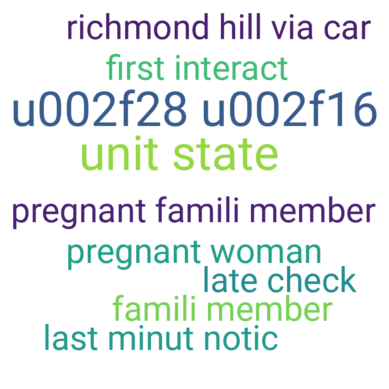

In [62]:
plotWordCloud(pmiposdf_bot_phrase['pmi'].head(counter).to_dict(), **wordcloud_args)

In [63]:
pminegdf_bot_phrase = pmiForAllCal(finaldf_bot_phrase, topk_bot_phrase, 'negative')
pminegdf_bot_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 55/55 [00:00<00:00, 868.06it/s]


pmi
u002f28 u002f16                0.693147
magic mushroom                 0.693147
last minut                     0.693147
sick famili member             0.693147
unit state                     0.693147
area plea                      0.693147
somewher el ye                 0.693147
entir facil need               0.693147
safeti other                   0.693147
credit card                    0.693147
male employe owner             0.693147
funni smell                    0.693147
unpleas smell                  0.693147
stale smoke                    0.693147
non smoke                      0.693147
next morn                      0.693147
night nthe                     0.693147
strong odor                    0.693147
broken tv                      0.693147
bathroom nwe                   0.693147
second towel                   0.693147
next day                       0.693147
n4 tbug                        0.693147
facil anyon                    0.693147
sofa chair n3 tthe water       0.693147
u002f27 u002f16                0.693147
pregnant famili member         0.693147
famili member                  0.693147
pregnant woman                 0.693147
late check                     0.693147
richmond hill via car          0.693147
first interact                 0.693147
dirti sheet n2 tunclean chair  0.693147
last minut notic               0.693147
morn hour                      0.693147
custom servic                  0.693147
time frame                     0.693147
bed terrifi                    0.693147
window unclean sheet           0.693147
unclean spider web             0.693147
famili nthi                    0.693147
home u2019t                    0.693147
condit anyon                   0.693147
nthe manag                     0.693147
motel famili                   0.693147
larg open                      0.693147
good restaur                  -8.517193
mainten man                   -8.517193
seren place                   -8.517193
super help amd quick check    -8.517193

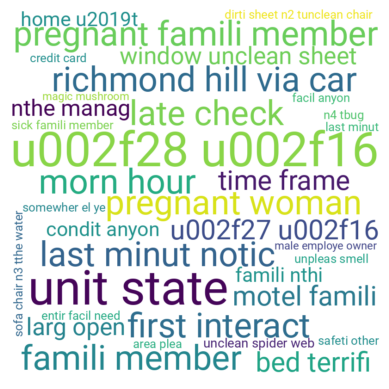

In [64]:
plotWordCloud(pminegdf_bot_phrase['pmi'].head(35).to_dict(), **wordcloud_args)

According to above we can infer that the top rated hotel has delicious breakfast and good location! Bottom rated hotel has bad smell and are unfriendly to pregnant woman.

## Data Visualizationa

### Histograms

Histograms of ground truth and Vader sentiment scores (ignore hotel ID).

In [65]:
columnNames = ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode']

hotelDf = pd.read_csv('/content/gdrive/MyDrive/reviews.csv',
                          header=None,
                          names=columnNames)
reviews = hotelDf['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df = True, columns = ['reviewCol','vader_sentiment'])
topk = getTopKWords(reviewDF, 500)
finaldf = dataFrameTransformation(hotelDf, reviewDF, topk)

100%|██████████| 2060/2060 [00:04<00:00, 473.29it/s]


In [66]:
def getHistogram(df, measure, title, figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)

    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

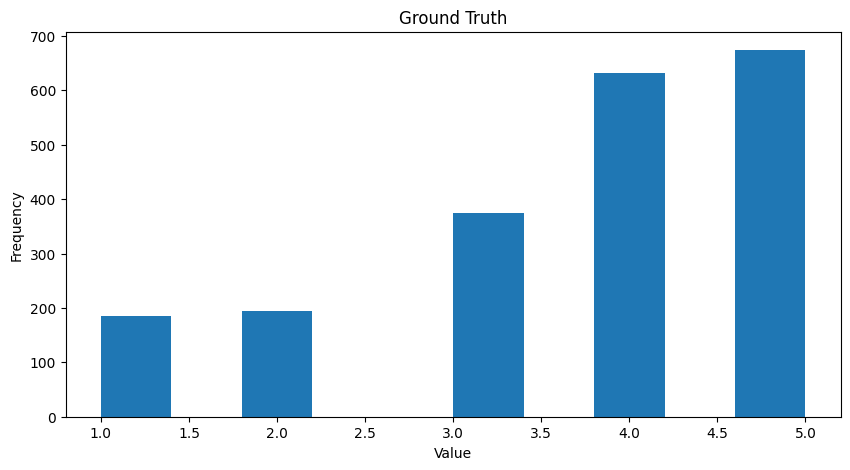

In [67]:
getHistogram(finaldf, 'ratingScore', 'Ground Truth')

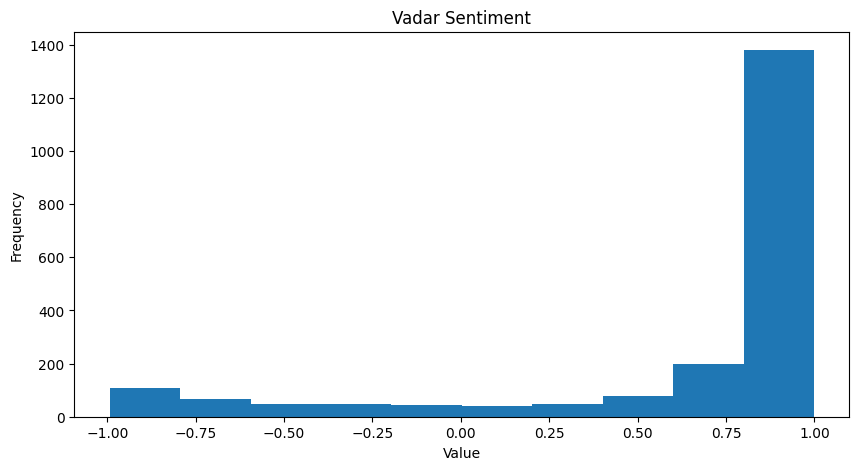

In [68]:
getHistogram(finaldf, 'vader_sentiment', 'Vadar Sentiment')

Ground truth are left-skewed, and vadar snetiment has one bar that is much higher than the others.

Histogram of the number of reviews per hotel:

Text(0.5, 1.0, ' histogram of the number of reviews per hotel')

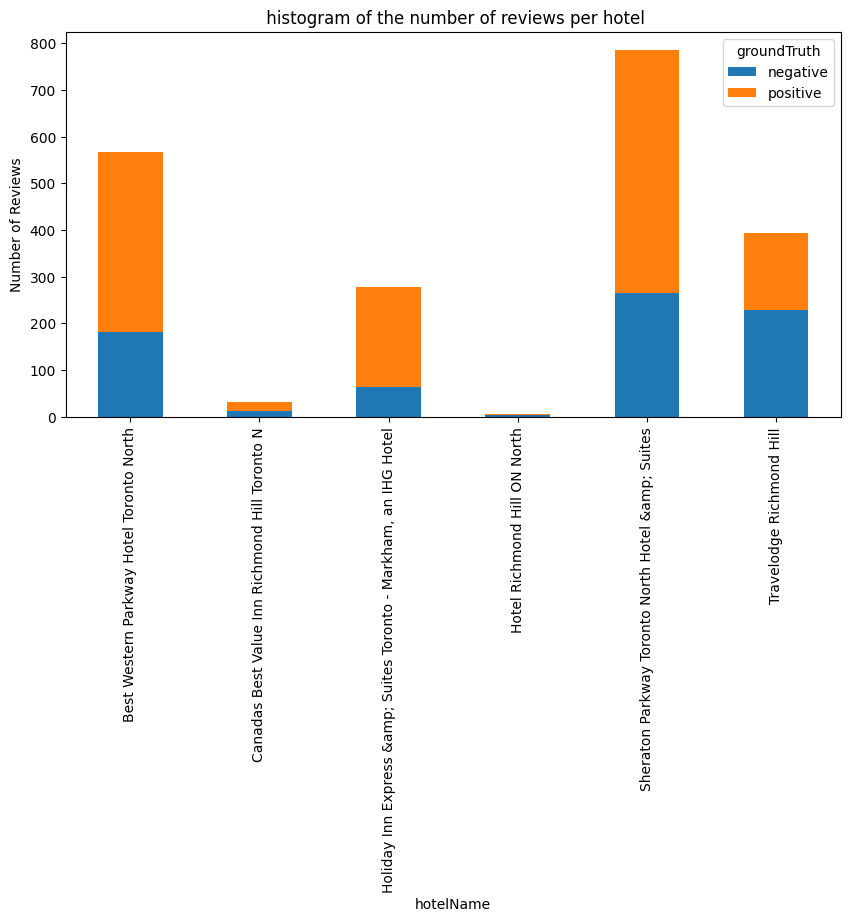

In [69]:
review_hotel=hotelDf.groupby(['hotelName', 'groundTruth']).size().unstack('groundTruth').fillna(0)
review_hotel.plot(kind='bar', stacked=True,figsize=(10,5))

plt.ylabel('Number of Reviews')
plt.title(' histogram of the number of reviews per hotel')

The reviews are slightly unbalenced towrad positive reviews.(more positive reviews)

### Boxplots

One for ground truth star rating and one for Vader sentiment side-by-side boxplots of these scores for the top-5 ranked hotels according to star rating.

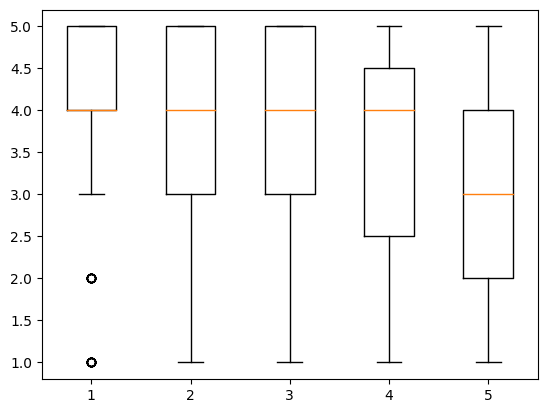

In [71]:
gt5hotel = hotelRatingDfAGT.sort_values('avg_ratingScore',ascending=0).head(5)

hotel1 = finaldf.loc[finaldf['hotelName'] == gt5hotel['hotelName'].values[0]]['ratingScore']
hotel2 = finaldf.loc[finaldf['hotelName'] == gt5hotel['hotelName'].values[1]]['ratingScore']
hotel3 = finaldf.loc[finaldf['hotelName'] == gt5hotel['hotelName'].values[2]]['ratingScore']
hotel4 = finaldf.loc[finaldf['hotelName'] == gt5hotel['hotelName'].values[3]]['ratingScore']
hotel5 = finaldf.loc[finaldf['hotelName'] == gt5hotel['hotelName'].values[4]]['ratingScore']

data_gt = [hotel1, hotel2, hotel3, hotel4, hotel5]
plt.figure()
plt.boxplot(data_gt)
plt.show()

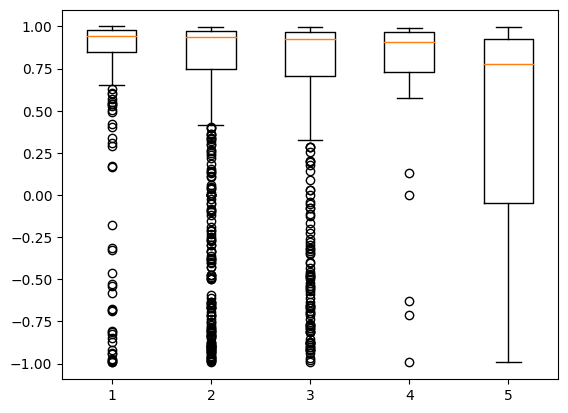

In [72]:
vs5hotel = hotelRatingDfAVS.sort_values('avg_vader_sentiment',ascending=0).head(5)

hotel1 = finaldf.loc[finaldf['hotelName'] == vs5hotel['hotelName'].values[0]]['vader_sentiment']
hotel2 = finaldf.loc[finaldf['hotelName'] == vs5hotel['hotelName'].values[1]]['vader_sentiment']
hotel3 = finaldf.loc[finaldf['hotelName'] == vs5hotel['hotelName'].values[2]]['vader_sentiment']
hotel4 = finaldf.loc[finaldf['hotelName'] == vs5hotel['hotelName'].values[3]]['vader_sentiment']
hotel5 = finaldf.loc[finaldf['hotelName'] == vs5hotel['hotelName'].values[4]]['vader_sentiment']

data_vader = [hotel1, hotel2, hotel3, hotel4, hotel5]
plt.figure()
plt.boxplot(data_vader)
plt.show()

The mean and variance of the ground truth and Vader sentiment scores for the
top-5 ranked hotels according to star rating.

In [73]:
results=[]
for hotel in data_gt:
    results.append([hotel.mean(), hotel.var()])
    results_df = pd.DataFrame(results)
    results_df.columns = ['mean','variance']
results_df

mean  variance
0  4.068100  1.243547
1  3.800353  1.501664
2  3.777070  1.553555
3  3.419355  1.984946
4  3.101781  1.566145

In [74]:
results=[]
for hotel in data_vader:
    results.append([hotel.mean(), hotel.var()])
    results_df = pd.DataFrame(results)
    results_df.columns = ['mean','variance']
results_df

mean  variance
0  0.764348  0.225859
1  0.679946  0.295935
2  0.679168  0.277161
3  0.671152  0.287857
4  0.412877  0.407327

Boxplots provide a clear visual representation of the median (central tendency) and the interquartile range (spread) of the data. The box itself covers the interquartile range, and the line inside the box represents the median. In addition, Boxplots effectively identify potential outliers in the data.

### Scatterplots and heatmaps

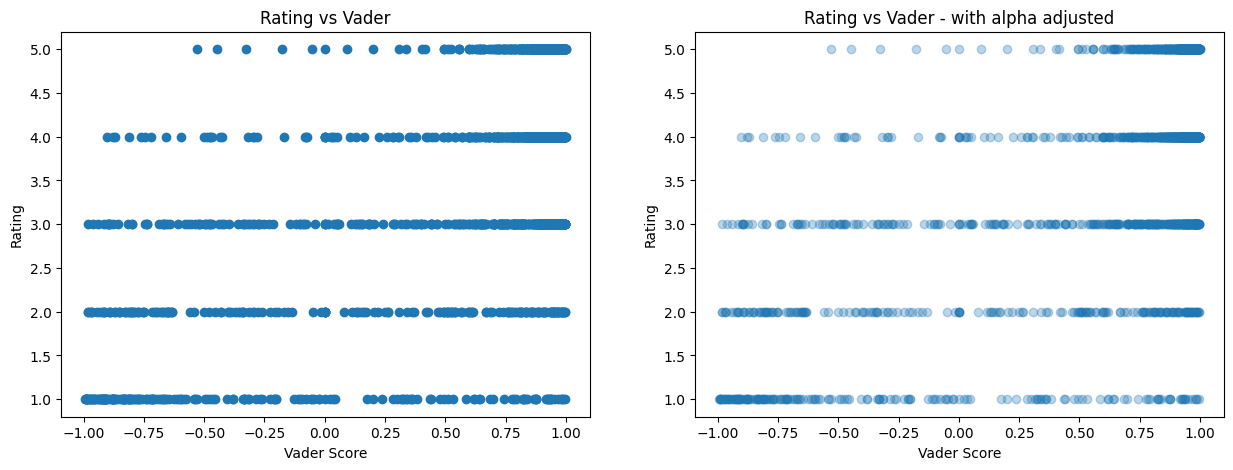

In [75]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader_sentiment'].values
ax[0].plot(vader_scores, rating_scores,"o")
ax[1].plot(vader_scores, rating_scores,"o", alpha=0.3)

ax[0].set_title('Rating vs Vader')
ax[1].set_title('Rating vs Vader - with alpha adjusted')

for _ax in ax:
  _ax.set_ylabel('Rating')
  _ax.set_xlabel('Vader Score')

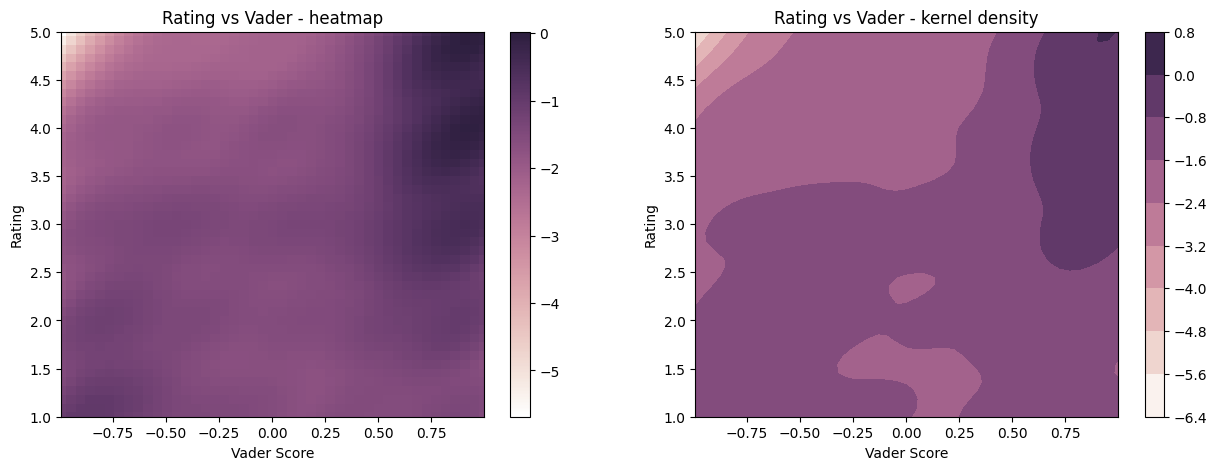

In [76]:
k = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
b2 = ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(rating_scores.min(), rating_scores.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(rating_scores.min(), rating_scores.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Rating vs Vader - heatmap')
ax2.set_title('Rating vs Vader - kernel density');

Scatter plot shows that higher rate reviews have higher vader score. The heatmap shows the same thing. This tells that start ratings has discrite values but it's not the case for vader score

Below are two scatterplots and two heatmaps of the length of reviews versus each of ground truth score and Vader sentiment score. Each review is a point on the scatterplot.

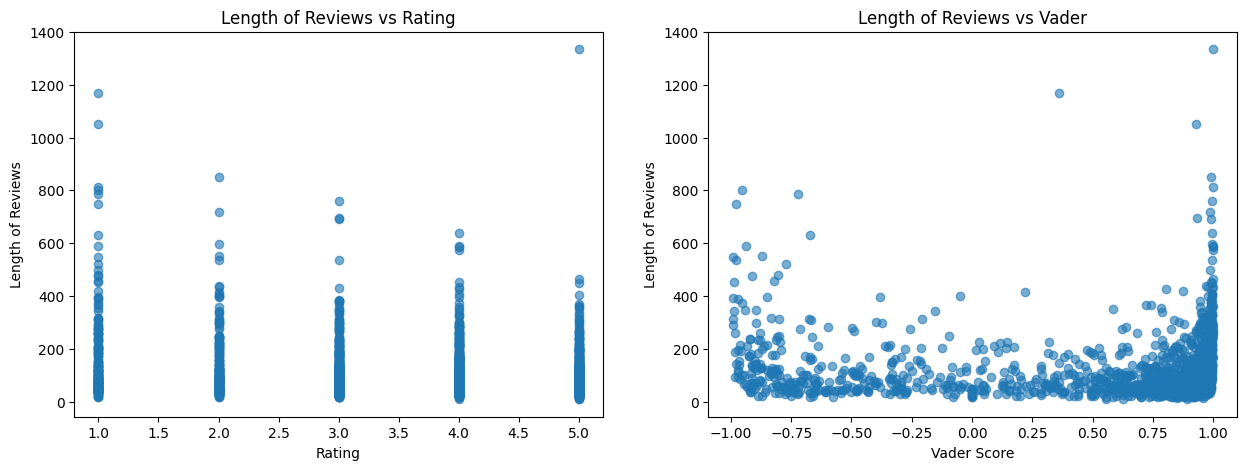

In [77]:
length_reviews = finaldf['reviewCol'].apply(lambda x: len(x.split()))

fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader_sentiment'].values
ax[0].plot(rating_scores, length_reviews, "o", alpha=0.6)
ax[1].plot(vader_scores, length_reviews, "o", alpha=0.6)

ax[0].set_title('Length of Reviews vs Rating')
ax[1].set_title('Length of Reviews vs Vader')

ax[0].set_xlabel('Rating')
ax[1].set_xlabel('Vader Score')
for _ax in ax:
  _ax.set_ylabel('Length of Reviews')
fig.show()

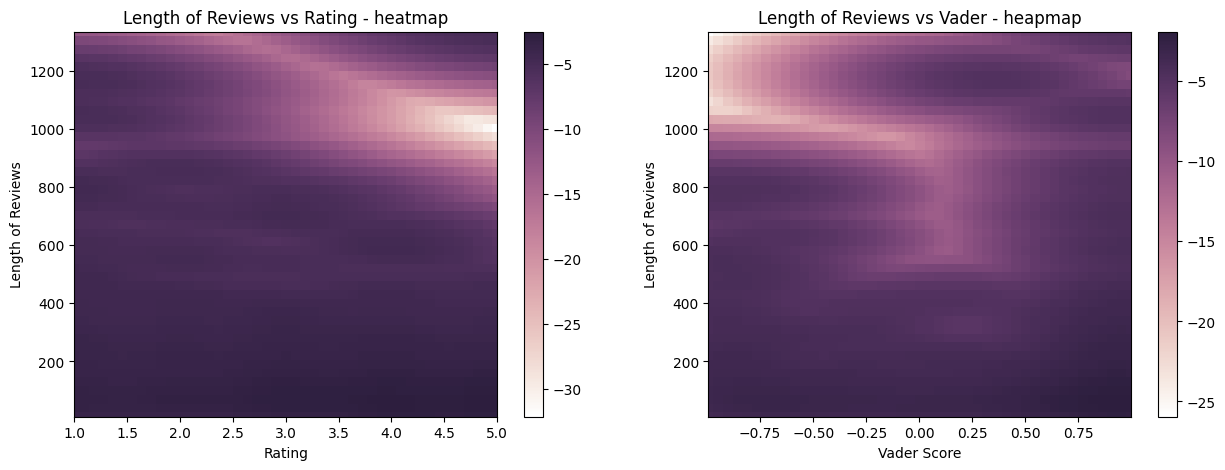

In [78]:
k1 = gaussian_kde(np.vstack([rating_scores, length_reviews]))
k2 = gaussian_kde(np.vstack([vader_scores, length_reviews]))

x1, y1 = np.mgrid[rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j,length_reviews.min():length_reviews.max():length_reviews.size**0.5*1j]
z1 = k1(np.vstack([x1.flatten(), y1.flatten()]))

x2, y2 = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,length_reviews.min():length_reviews.max():length_reviews.size**0.5*1j]
z2 = k2(np.vstack([x2.flatten(), y2.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(x1, y1, np.log10(z1.reshape(x1.shape)), cmap=cmap)
b2 = ax2.pcolormesh(x2, y2, np.log10(z2.reshape(x2.shape)), cmap=cmap)

ax1.set_xlim(rating_scores.min(), rating_scores.max())
ax1.set_ylim(length_reviews.min(), length_reviews.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(length_reviews.min(), length_reviews.max())

ax1.set_xlabel('Rating')
ax1.set_ylabel('Length of Reviews')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Length of Reviews')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Length of Reviews vs Rating - heatmap')
ax2.set_title('Length of Reviews vs Vader - heapmap');

From vader score's point of view, people tend to give longer review of high and low vader score.


From ratings point of view, people tend to give longer reviews for low rating.

### Location-based patterns

Using folium2 and the reported location data, below is a visualization of the location of the hotels on a map. we have adjust the labels to reflect their average ground truth sentiment values.

In [80]:
def make_address(row):
  # individual columns need to be combined
  return row['streetAddress']+", "+row['City']+", "+row['Province']

In [81]:
hotelRatingDfAGT.set_index('hotelName', inplace=True)
hotelRatingDfAGT.head()

avg_ratingScore
hotelName                                                          
Holiday Inn Express &amp; Suites Toronto - Mark...         4.068100
Best Western Parkway Hotel Toronto North                   3.800353
Sheraton Parkway Toronto North Hotel &amp; Suites          3.777070
Canadas Best Value Inn Richmond Hill Toronto N             3.419355
Travelodge Richmond Hill                                   3.101781

In [82]:
# Need the location for each hotel in a format the tool can handle
geo_rating_df = hotelRatingDfAGT\
                         .join(hotelDf.groupby('hotelName')\
                         .agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))
geo_rating_df.head()
geo_rating_df['formed_address'] = geo_rating_df.apply(make_address , axis=1)
geo_rating_df = geo_rating_df.head()

In [83]:
# 0 - need to give the tool a generic name.
locator = Photon(user_agent='myGeocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2 - form the location string
geo_rating_df['location'] = geo_rating_df['formed_address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
geo_rating_df['point'] = geo_rating_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
geo_rating_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(geo_rating_df['point'].tolist(), index=geo_rating_df.index)

geo_rating_df.head()

avg_ratingScore  \
hotelName                                                             
Holiday Inn Express &amp; Suites Toronto - Mark...         4.068100   
Best Western Parkway Hotel Toronto North                   3.800353   
Sheraton Parkway Toronto North Hotel &amp; Suites          3.777070   
Canadas Best Value Inn Richmond Hill Toronto N             3.419355   
Travelodge Richmond Hill                                   3.101781   

                                                                                        streetAddress  \
hotelName                                                                                               
Holiday Inn Express &amp; Suites Toronto - Mark...                              10 East Pearce Street   
Best Western Parkway Hotel Toronto North                                              600 Highway 7 E   
Sheraton Parkway Toronto North Hotel &amp; Suites                                       600 Highway 7   
Canadas Best Value Inn Richmond Hill Toronto N      13100 Yonge Street intersection of Yonge Stree...   
Travelodge Richmond Hill                                                               10711 Yonge St   

                                                                  City  \
hotelName                                                                
Holiday Inn Express &amp; Suites Toronto - Mark...  ('Richmond Hill',)   
Best Western Parkway Hotel Toronto North            ('Richmond Hill',)   
Sheraton Parkway Toronto North Hotel &amp; Suites   ('Richmond Hill',)   
Canadas Best Value Inn Richmond Hill Toronto N      ('Richmond Hill',)   
Travelodge Richmond Hill                            ('Richmond Hill',)   

                                                   Province postalCode  \
hotelName                                                                
Holiday Inn Express &amp; Suites Toronto - Mark...  Ontario    L4B 0A8   
Best Western Parkway Hotel Toronto North            Ontario    L4B 1B2   
Sheraton Parkway Toronto North Hotel &amp; Suites   Ontario    L4B 1B2   
Canadas Best Value Inn Richmond Hill Toronto N      Ontario    L4E 1A6   
Travelodge Richmond Hill                            Ontario    L4C 3E1   

                                                                                       formed_address  \
hotelName                                                                                               
Holiday Inn Express &amp; Suites Toronto - Mark...  10 East Pearce Street, ('Richmond Hill',), Ont...   
Best Western Parkway Hotel Toronto North                 600 Highway 7 E, ('Richmond Hill',), Ontario   
Sheraton Parkway Toronto North Hotel &amp; Suites          600 Highway 7, ('Richmond Hill',), Ontario   
Canadas Best Value Inn Richmond Hill Toronto N      13100 Yonge Street intersection of Yonge Stree...   
Travelodge Richmond Hill                                  10711 Yonge St, ('Richmond Hill',), Ontario   

                                                                                             location  \
hotelName                                                                                               
Holiday Inn Express &amp; Suites Toronto - Mark...  (10, East Pearce Street, L4B 2N2, East Pearce ...   
Best Western Parkway Hotel Toronto North            (600, Highway 7, L4B 1B2, Highway 7, Richmond ...   
Sheraton Parkway Toronto North Hotel &amp; Suites   (600, Highway 7, L4B 1B2, Highway 7, Richmond ...   
Canadas Best Value Inn Richmond Hill Toronto N      (Yonge Street / King Road, Yonge Street, L4E 3...   
Travelodge Richmond Hill                            (Travelodge, 10711, Yonge Street, L4C 3E1, Yon...   

                                                                                    point  \
hotelName                                                                                   
Holiday Inn Express &amp; Suites Toronto - Mark...           (43.848668, -79.383127, 0.0)   
Best Western Parkway Hotel To

In [84]:
import branca.colormap as cm
colormap = cm.LinearColormap(colors=[(68,1,84),(49,104,142),(53,183,121),(253,231,37)], index=[2,3,4,5],vmin=2,vmax=5)
AverageGroundTruthRating_list = list(geo_rating_df["avg_ratingScore"])
avg_latitude = geo_rating_df['latitude'].mean()
avg_longitude = geo_rating_df['longitude'].mean()


map1 = folium.Map(
    location=[avg_latitude, avg_longitude], # <- this will need to be set based on your own hotels
    tiles='cartodbpositron',
    zoom_start=12,
)

coordinates = zip(geo_rating_df.latitude, geo_rating_df.longitude)
for coordinate, rating in zip(coordinates, AverageGroundTruthRating_list):
    folium.CircleMarker(
        location = coordinate,
        radius=10,
        fill=True,
        color=colormap(rating),
        fill_opacity = 1
    ).add_to(map1)

map1.add_child(colormap)
map1


A static image of above visualization.

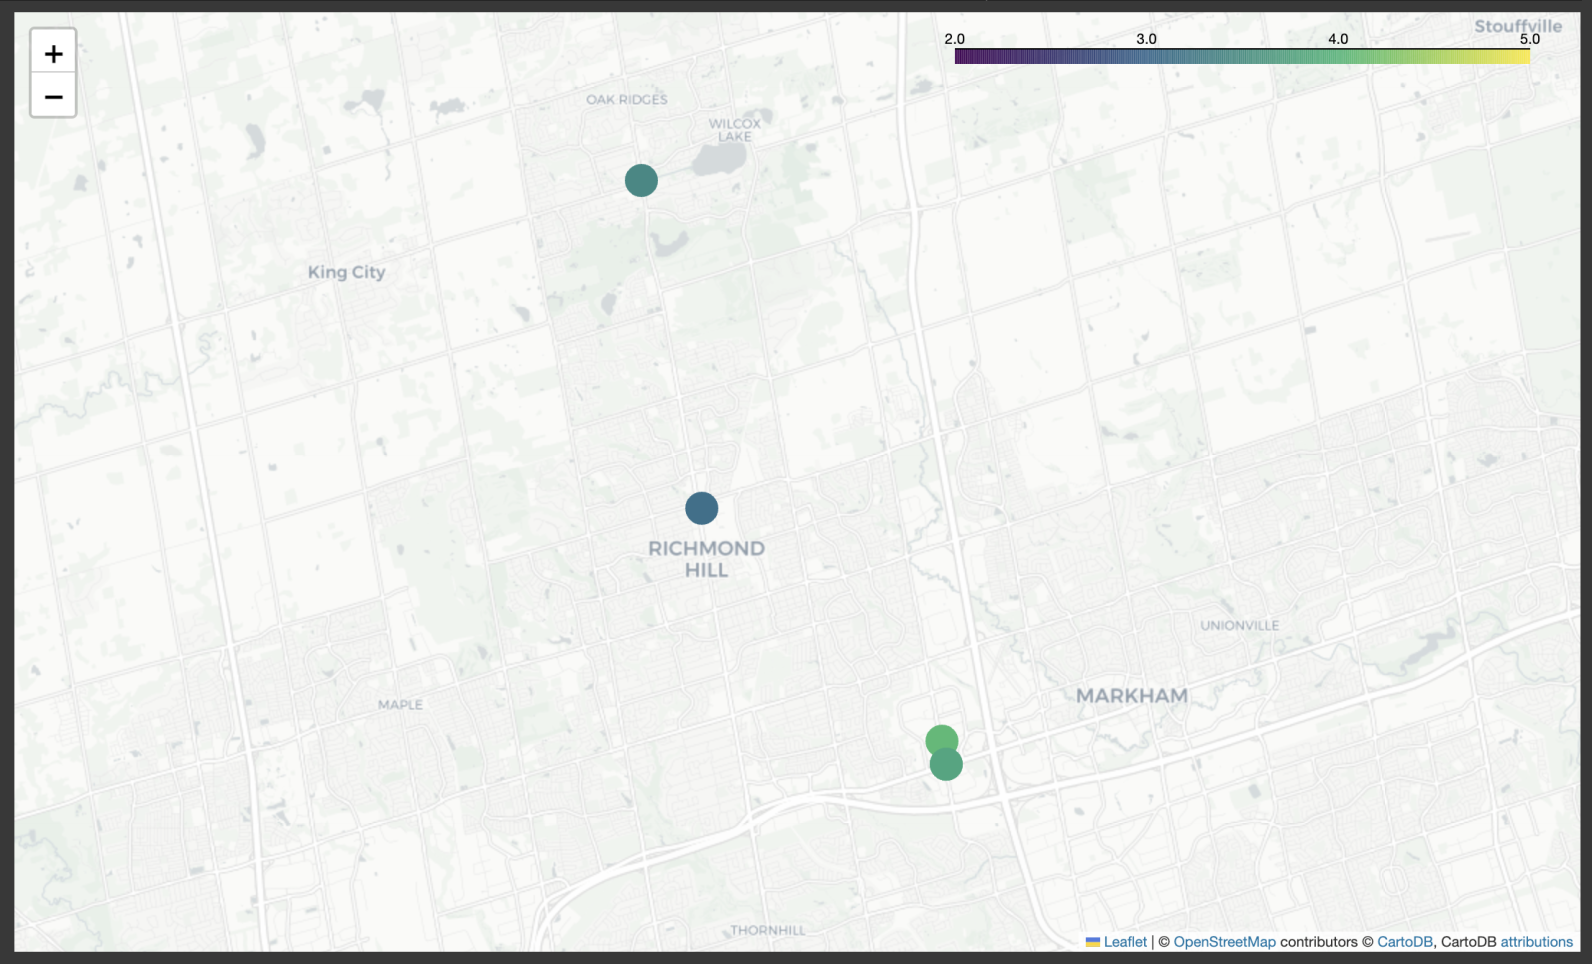

In [85]:
from IPython.display import Image, display

# Specify the path to your image file
image_path = '/content/gdrive/MyDrive/1.png'

# Display the image
display(Image(filename=image_path))

Seems like the hotels that are closer to highways have better rating. Hence I would recommend location close to the crosing of two highways if someone what to build a new hotel.

### Temporal analysis

In [86]:
six_hotels = hotelRatingDfAGT.index.values
print(six_hotels)
date_stampDf = hotelDf[~hotelDf.date_stamp.str.contains('|'.join(['ago', 'yesterday']))].reset_index(drop=True)

['Holiday Inn Express &amp; Suites Toronto - Markham, an IHG Hotel'
 'Best Western Parkway Hotel Toronto North'
 'Sheraton Parkway Toronto North Hotel &amp; Suites'
 'Canadas Best Value Inn Richmond Hill Toronto N'
 'Travelodge Richmond Hill' 'Hotel Richmond Hill ON North']


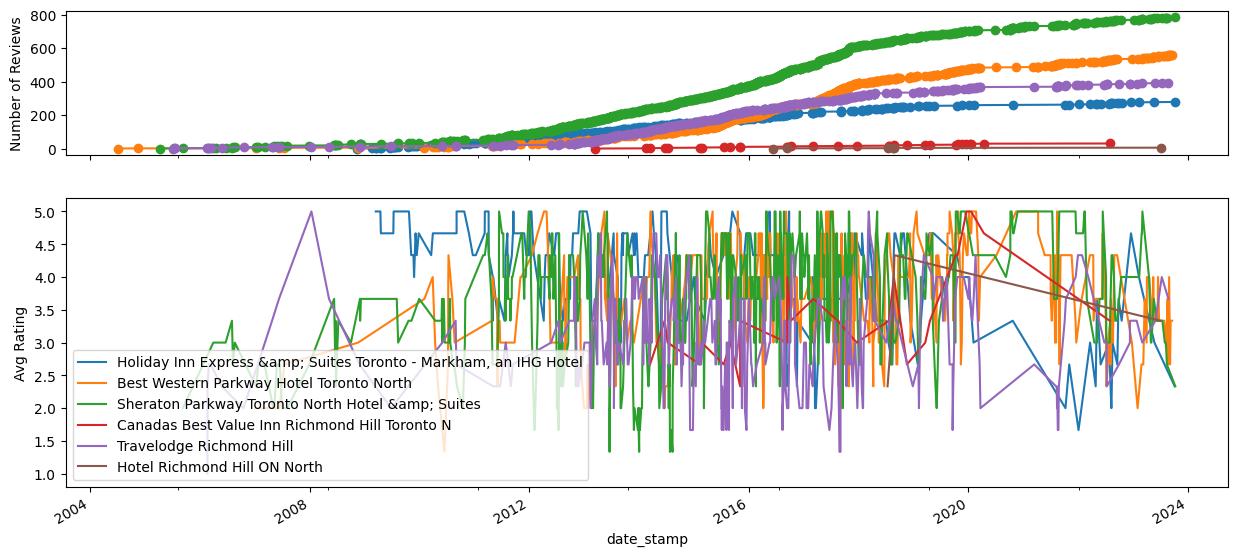

In [87]:
# It can be useful to see when reviews were being made and how the ratings changed using a running mean
fig, ax = plt.subplots(2, 1, figsize=(15,7),
                       sharex=True,
                       gridspec_kw={
                           'height_ratios': [1, 2]})

for hotel in six_hotels:
  _df = date_stampDf[date_stampDf['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df['count'].cumsum().plot(ax=ax[0],label=hotel, marker='o')
  _df['ratingScore'].rolling(3).mean().plot(ax=ax[1],label=hotel)

ax[1].set_ylabel('Avg Rating')
ax[0].set_ylabel('Number of Reviews')
plt.legend()

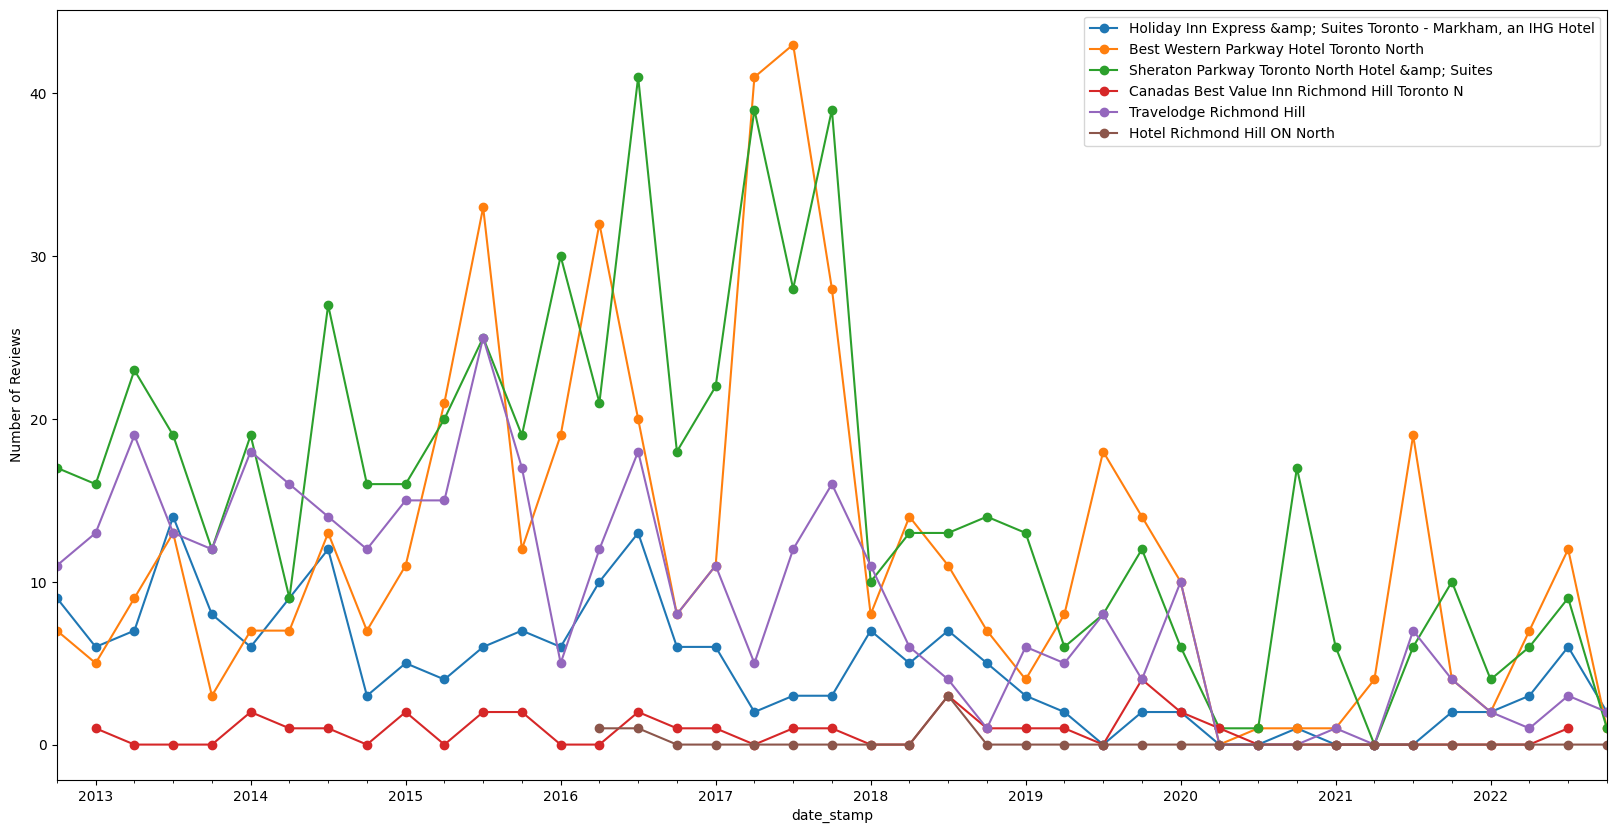

In [88]:
plt.figure(figsize=(20,10))

for hotel in six_hotels:
  _df = date_stampDf[date_stampDf['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='Q')).agg({'count':'sum'})
  _df_monthly = _df_monthly['12/31/2012':'12/31/2022']

  _df_monthly['count'].plot(label=hotel, marker='o')

plt.ylabel('Number of Reviews')
plt.legend()
plt.show()

From rolling average score shown above, we ca see that top rated hotels are more consistent, lowly rated hotels’ ratings fluctuate.


I plot rate of reviews (i.e., the number of reviews in a fixed time period) for each hotel over recent decade. From the graph we can see that ther are a large number of reviews between 2016-2018 (one reason can be tripadvisor becomes popular in that time)